# Process Parameter Optimization

In [1]:
# ! pip install -r requirements.txt

## Libraries

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

In [3]:
from utils.data_fetch import read_data
data = read_data()

C:\Users\Vardan\AppData\Local\Temp\ipykernel_12612\1164869249.py:2: DeprecationWarning: [Deprecated][in version 6.0.0]: client_factory will be replaced by gspread.http_client types
  data = read_data()


## Data Analysis

In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 27 entries, 0 to 26
Data columns (total 5 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   Spindle Speed     27 non-null     float64
 1   Feed (mm/min)     27 non-null     float64
 2   Tool Dia. (mm)    27 non-null     float64
 3   MRR (mm^3 / min)  27 non-null     float64
 4   L_e               27 non-null     float64
dtypes: float64(5)
memory usage: 1.2 KB


array([[<Axes: title={'center': 'Spindle Speed'}>,
        <Axes: title={'center': 'Feed (mm/min)'}>],
       [<Axes: title={'center': 'Tool Dia. (mm)'}>,
        <Axes: title={'center': 'MRR (mm^3 / min)'}>],
       [<Axes: title={'center': 'L_e'}>, <Axes: >]], dtype=object)

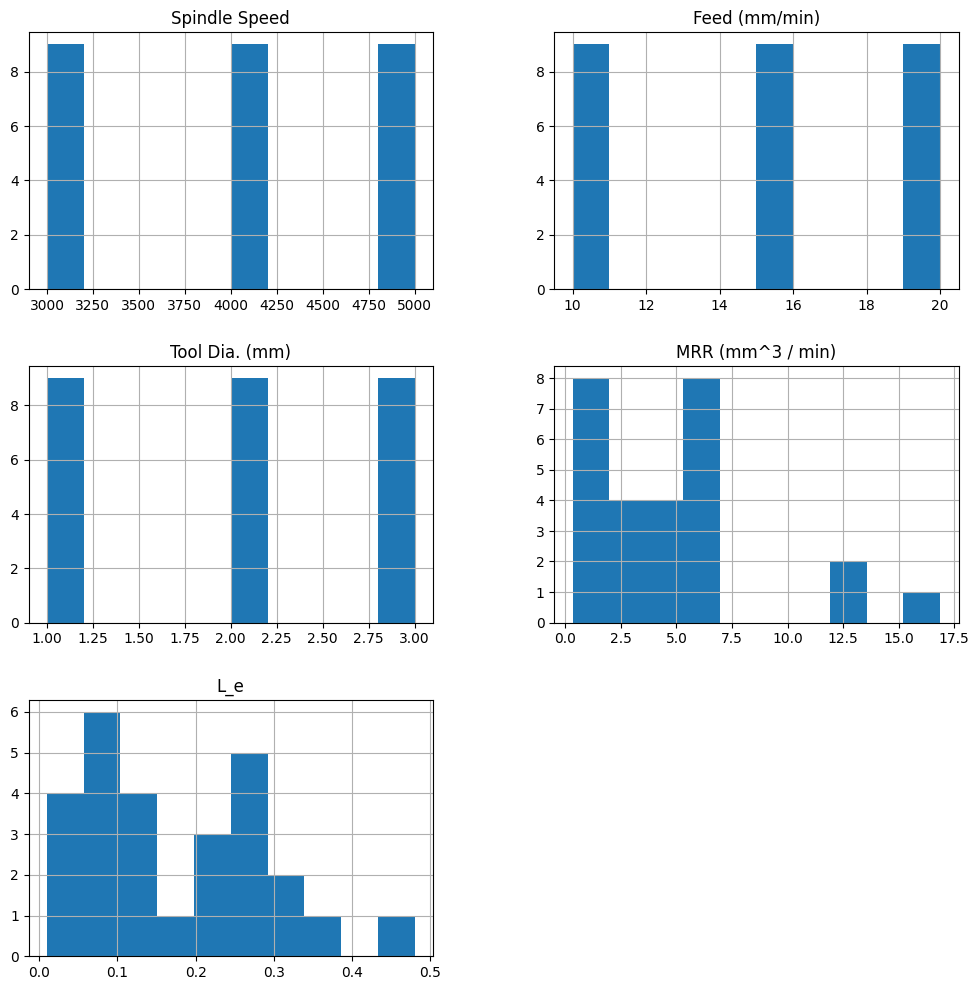

In [5]:
data.hist(figsize=(12,12))

In [6]:
corr_matrix = data.corr()

In [7]:
data.corr()["Spindle Speed"].sort_values()

MRR (mm^3 / min)   -6.447134e-02
Feed (mm/min)       1.313715e-16
Tool Dia. (mm)      2.273737e-16
L_e                 1.247300e-01
Spindle Speed       1.000000e+00
Name: Spindle Speed, dtype: float64

<Axes: >

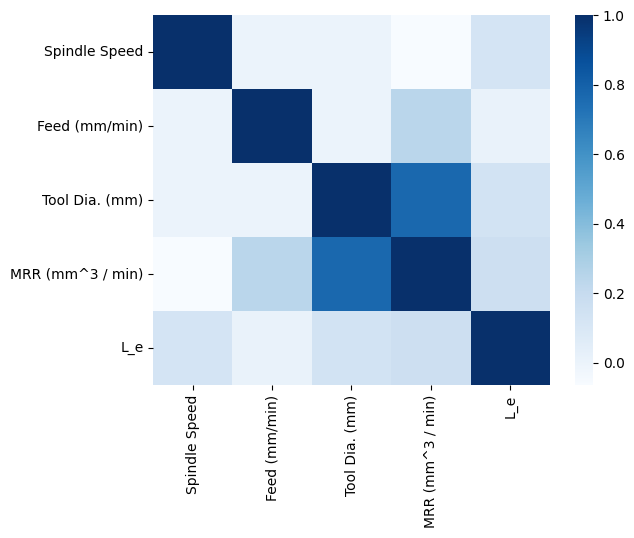

In [8]:
sns.heatmap(data.corr(), cmap='Blues')

In [18]:
data.corr()["L_e"].sort_values(ascending=False)

L_e                 1.000000
MRR (mm^3 / min)    0.166335
Tool Dia. (mm)      0.136423
Spindle Speed       0.124730
Feed (mm/min)       0.011693
Name: L_e, dtype: float64

array([[<Axes: xlabel='Tool Dia. (mm)', ylabel='Feed (mm/min)'>,
        <Axes: xlabel='L_e', ylabel='Feed (mm/min)'>,
        <Axes: xlabel='Feed (mm/min)', ylabel='Feed (mm/min)'>,
        <Axes: xlabel='Spindle Speed', ylabel='Feed (mm/min)'>],
       [<Axes: xlabel='Tool Dia. (mm)', ylabel='Spindle Speed'>,
        <Axes: xlabel='L_e', ylabel='Spindle Speed'>,
        <Axes: xlabel='Feed (mm/min)', ylabel='Spindle Speed'>,
        <Axes: xlabel='Spindle Speed', ylabel='Spindle Speed'>]],
      dtype=object)

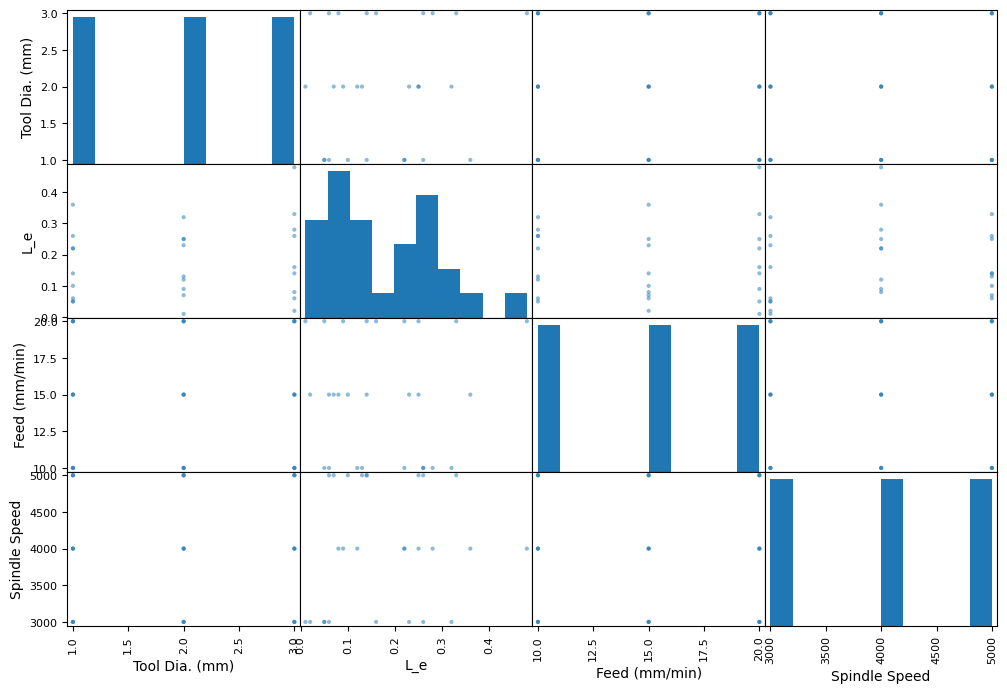

In [11]:
from pandas.plotting import scatter_matrix
attributes=["Tool Dia. (mm)", "L_e", "Feed (mm/min)", "Spindle Speed"]
scatter_matrix(data[attributes], figsize=(12, 8))[2:]

## Data Preprocessing

In [19]:
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
train_set, test_set = train_test_split(data, test_size=0.2, random_state=32)

In [20]:
X_train = train_set.drop(["L_e", "MRR (mm^3 / min)"], axis = 1)
y_train=pd.concat([train_set["L_e"], train_set["MRR (mm^3 / min)"]], axis=1)

In [21]:
features_name = X_train.columns
target_name = y_train.columns

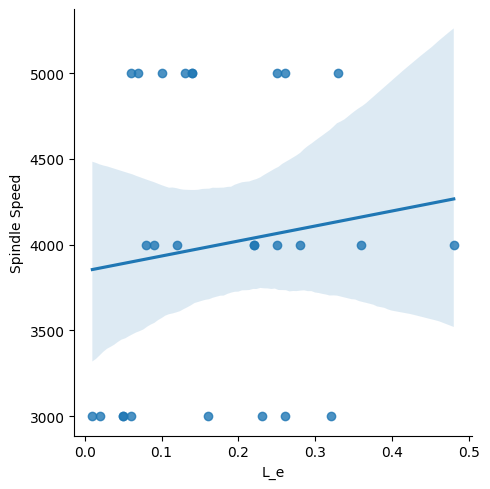

In [22]:
sns.lmplot(x ="L_e", y ="Spindle Speed", data = data)

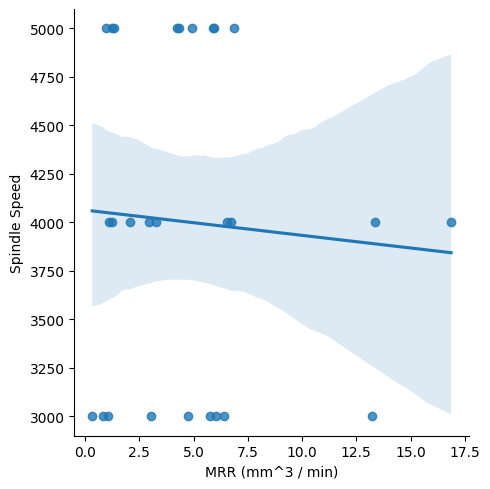

In [44]:
sns.lmplot(x ="MRR (mm^3 / min)", y ="Spindle Speed", data = data)

<Axes: xlabel='MRR (mm^3 / min)', ylabel='Feed (mm/min)'>

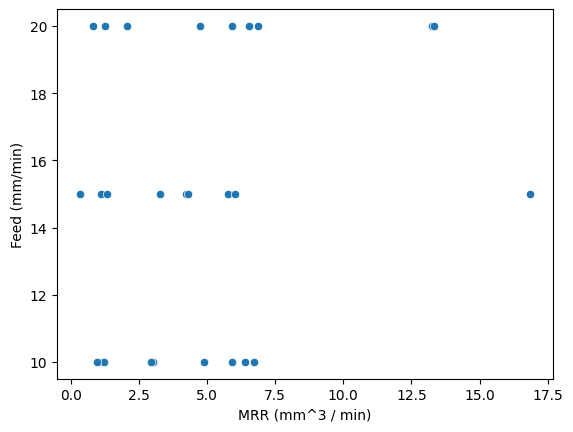

In [24]:
sns.scatterplot(data,x = "MRR (mm^3 / min)", y ="Feed (mm/min)")

## Model Selection

In [25]:
from sklearn.ensemble import RandomForestRegressor
rnd_reg = RandomForestRegressor(n_estimators=500, max_leaf_nodes=20, n_jobs=-1, max_depth=10)
rf_pipeline = Pipeline([
    ("scaler", StandardScaler()),
    ("Random Forest", rnd_reg)
])

rf_model = rf_pipeline.fit(X_train, y_train)

In [26]:
X_new = X_train[:3]

In [27]:
y_train[:3]

,L_e,MRR (mm^3 / min)
16,0.09,6.53
17,0.48,13.34
15,0.22,2.08


In [28]:
rf_model.predict(X_new)

array([[ 0.11334,  5.87116],
       [ 0.35106, 13.5677 ],
       [ 0.19202,  2.07372]])

In [29]:
estimator = rf_model.named_steps["Random Forest"].estimators_[0]

In [30]:
from utils.Visualizations import rf_visualize
rf_visualize(estimator, features_name,target_name)


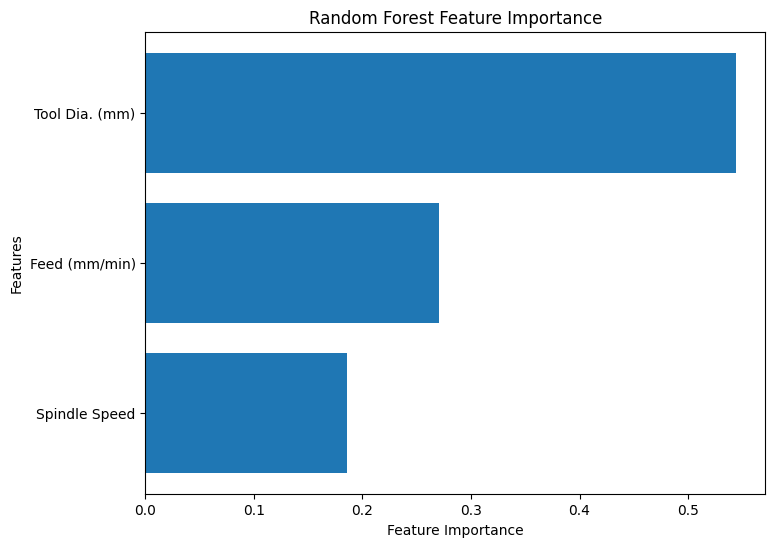

In [31]:
importances = rf_model.named_steps['Random Forest'].feature_importances_
plt.figure(figsize=(8, 6))
plt.barh(features_name, importances)
plt.xlabel('Feature Importance')
plt.ylabel('Features')
plt.title('Random Forest Feature Importance')
plt.show()

## Performance Testing

In [33]:
from utils.performace_checking import Performance_testing
Performance_testing(rf_model, X_train,y_train, 10)

Scores: [0.79479273 2.19819671 5.46659833 1.10920954 1.03424213 0.78659849
 1.57506521 1.43323729 3.43295477 4.19567632]
Mean: 2.202657153231754
Standard deviation: 1.538606311053472


## Model Optimization

In [34]:
from sklearn.model_selection import RandomizedSearchCV
random_grid = {
    "rnd_reg1__bootstrap":[True],
    "rnd_reg1__n_estimators":[50, 100, 150, 200, 250, 300, 350, 400, 450, 500, 550, 600],
    "rnd_reg1__max_depth":[10, 20, 25, 30, 35, 40, 45, 50, 55, 60,65, 70, 75, 80],
    "rnd_reg1__max_features":["auto","sqrt"],
    "rnd_reg1__min_samples_leaf":[1, 2, 3, 4],
    "rnd_reg1__min_samples_split":[2, 5, 7, 10, 13, 15, 17,20],
}

rnd_pipeline = Pipeline([
    ("scaler", StandardScaler()),
    ("rnd_reg1", RandomForestRegressor())
])
rnd_search = RandomizedSearchCV(rnd_pipeline, param_distributions=random_grid,cv=10,n_jobs=-1)


In [35]:
rnd_search.fit(X_train,y_train)

e:\Projects\Micromilling_process_optimisation\.venv\Lib\site-packages\sklearn\model_selection\_validation.py:425: FitFailedWarning: 
80 fits failed out of a total of 100.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
51 fits failed with the following error:
Traceback (most recent call last):
  File "e:\Projects\Micromilling_process_optimisation\.venv\Lib\site-packages\sklearn\model_selection\_validation.py", line 729, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "e:\Projects\Micromilling_process_optimisation\.venv\Lib\site-packages\sklearn\base.py", line 1152, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "e:\Projects\Micromilling_proc

RandomizedSearchCV(cv=10,
                   estimator=Pipeline(steps=[('scaler', StandardScaler()),
                                             ('rnd_reg1',
                                              RandomForestRegressor())]),
                   n_jobs=-1,
                   param_distributions={'rnd_reg1__bootstrap': [True],
                                        'rnd_reg1__max_depth': [10, 20, 25, 30,
                                                                35, 40, 45, 50,
                                                                55, 60, 65, 70,
                                                                75, 80],
                                        'rnd_reg1__max_features': ['auto',
                                                                   'sqrt'],
                                        'rnd_reg1__min_samples_leaf': [1, 2, 3,
                                                                       4],
                                        'rnd_reg1__min_samples_split': [2, 5, 7,
                                                                        10, 13,
                                                                        15, 17,
                                                                        20],
                                        'rnd_reg1__n_estimators': [50, 100, 150,
                                                                   200, 250,
                                                                   300, 350,
                                                                   400, 450,
                                                                   500, 550,
                                                                   600]})

In [36]:
rnd_search.best_estimator_

Pipeline(steps=[('scaler', StandardScaler()),
                ('rnd_reg1',
                 RandomForestRegressor(max_depth=80, max_features='sqrt',
                                       min_samples_leaf=4, min_samples_split=10,
                                       n_estimators=200))])

In [37]:
rnd_search.best_params_

{'rnd_reg1__n_estimators': 200,
 'rnd_reg1__min_samples_split': 10,
 'rnd_reg1__min_samples_leaf': 4,
 'rnd_reg1__max_features': 'sqrt',
 'rnd_reg1__max_depth': 80,
 'rnd_reg1__bootstrap': True}

In [38]:
from utils.model_testing import test_score
test_score(rnd_search, X_train,y_train)

The mean square error is 2.4661840702605478 and the r2 score is 0.16659109985460824.


In [41]:
from sklearn.model_selection import GridSearchCV
grid = {
    "grid__bootstrap":[True],
    "grid__n_estimators":[160, 170, 190, 200, 210, 220, 230, 240],
    "grid__max_depth":[80, 85, 90, 95, 100, 105],
    "grid__min_samples_leaf":[4, 5, 6,7, 8, 9, 10],
    "grid__min_samples_split":[10, 11, 12]}

grid_pipeline = Pipeline([
    ("scaler", StandardScaler()),
    ("grid", RandomForestRegressor())
])
grid_search = GridSearchCV(grid_pipeline, param_grid=grid,cv=10,n_jobs=-1)

In [42]:
grid_search.fit(X_train,y_train)

GridSearchCV(cv=10,
             estimator=Pipeline(steps=[('scaler', StandardScaler()),
                                       ('grid', RandomForestRegressor())]),
             n_jobs=-1,
             param_grid={'grid__bootstrap': [True],
                         'grid__max_depth': [80, 85, 90, 95, 100, 105],
                         'grid__min_samples_leaf': [4, 5, 6, 7, 8, 9, 10],
                         'grid__min_samples_split': [10, 11, 12],
                         'grid__n_estimators': [160, 170, 190, 200, 210, 220,
                                                230, 240]})

In [43]:
grid_search.best_params_

{'grid__bootstrap': True,
 'grid__max_depth': 80,
 'grid__min_samples_leaf': 10,
 'grid__min_samples_split': 12,
 'grid__n_estimators': 170}

In [45]:
test_score(grid_search, X_train,y_train)

The mean square error is 2.889152051010974 and the r2 score is -0.0001932037835579159.


In [46]:
final_model = rnd_search.best_estimator_

In [47]:
final_model.fit(X_train,y_train)

Pipeline(steps=[('scaler', StandardScaler()),
                ('rnd_reg1',
                 RandomForestRegressor(max_depth=80, max_features='sqrt',
                                       min_samples_leaf=4, min_samples_split=10,
                                       n_estimators=200))])

In [48]:
estimator = final_model.named_steps["rnd_reg1"].estimators_[0]

In [49]:
rf_visualize(estimator,features_name,target_name)

In [50]:
Performance_testing(final_model,X_train,y_train,10)

Scores: [3.11414988 3.64506004 5.75431833 1.28724657 0.51160439 2.59838318
 3.63024504 0.80167972 0.52070593 1.07415238]
Mean: 2.293754546902864
Standard deviation: 1.6552980935677732


In [51]:
import joblib
joblib.dump(final_model,"Random_Forest_Model.pkl")

['Random_Forest_Model.pkl']

In [52]:
model = joblib.load("Random_Forest_Model.pkl")

## Models Testing

In [55]:
X_test = test_set.drop(["L_e", "MRR (mm^3 / min)"], axis = 1)
y_test=pd.concat([test_set["L_e"], test_set["MRR (mm^3 / min)"]], axis=1)

In [56]:
from utils.model_testing import test_score
test_score(model, X_test, y_test)

The mean square error is 2.446281092131017 and the r2 score is -0.7756302014637111.


In [57]:
test_score(model, X_train,y_train)

The mean square error is 2.462093946120227 and the r2 score is 0.16481172032388924.
